# Emergency Room Efficiency Analysis
## Meridian City Hospital - East ER Location

**Objective:** Identify bottlenecks causing ER delays and provide actionable recommendations

**Key Metrics:**
- Only 40% of patients seen within 15 minutes
- Average wait time: 45+ minutes
- Average total ER time: 2.5 hours

---

## 1. Setup and Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor


# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [2]:
# Load datasets
patients = pd.read_csv('data/Hospital_Patients.csv')
visits = pd.read_csv('data/Hospital_Visits.csv')
staffing = pd.read_csv('data/Hospital_Staffing_EAST_LOCATION.csv')
facility = pd.read_csv('data/Hospital_Facility.csv')
outcomes = pd.read_csv('data/Hospital_Outcomes.csv')

print(f"📊 Patients: {len(patients):,} records")
print(f"📊 Visits: {len(visits):,} records")
print(f"📊 Staffing: {len(staffing):,} records")
print(f"📊 Outcomes: {len(outcomes):,} records")
print(f"📊 Facilities: {len(facility):,} records")

📊 Patients: 4,500 records
📊 Visits: 18,000 records
📊 Staffing: 270 records
📊 Outcomes: 15,000 records
📊 Facilities: 2 records


In [3]:
# Quick data preview
print("=" * 60)
print("VISITS DATA SAMPLE")
print("=" * 60)
display(visits.head(3))

print("\n" + "=" * 60)
print("STAFFING DATA SAMPLE")
print("=" * 60)
display(staffing.head(3))

VISITS DATA SAMPLE


,Visit ID,Patient ID,Arrival Time,Registration Start,Registration End,Triage Start,Triage End,Doctor Seen,Exit Time,Triage Level,Hospital ID
0,W112965,MC180325-1393,3/9/2025 3:44,3/9/2025 3:38,Mar 09 2025 03:21,2025-03-09T03:27,3/9/2025 3:40,3/9/2025 4:17,3/9/2025 6:26,moderate,MC_ER_WEST
1,W113095,MC180325-1007,3/8/2025 4:01,3/8/2025 5:05,Mar 08 2025 04:28,2025-03-08T04:32,3/8/2025 4:55,3/8/2025 4:39,3/8/2025 8:10,2,MC_ER_WEST
2,W106220,MC180325-1088,2/7/2025 15:22,2/7/2025 15:08,Feb 07 2025 15:54,2025-02-07T16:01,2/7/2025 16:17,2/7/2025 15:58,2/7/2025 19:33,1,MC_ER_WEST



STAFFING DATA SAMPLE


,Date,Shift,Nurses On Duty,Doctors On Duty,Specialists On Call,Fast Track Beds
0,1/1/2025,Day,7,4,3,6
1,1/1/2025,Evening,7,4,2,3
2,1/1/2025,NIGHT,7,2,3,4


## 2. Data Cleaning and Preparation

**Issues to fix:**
1. Inconsistent date formats
2. Inconsistent shift capitalization
3. Inconsistent triage level formats
4. Filter for East ER only

In [4]:
# Filter for East ER only (per project requirements)
print(f"Total visits before filtering: {len(visits):,}")
visits = visits[visits['Hospital ID'] == 'MC_ER_EAST'].copy()
print(f"East ER visits only: {len(visits):,}")
print(f"Filtered out: {len(visits[visits['Hospital ID'] != 'MC_ER_EAST']):,} West ER visits")

Total visits before filtering: 18,000
East ER visits only: 15,000
Filtered out: 0 West ER visits


In [5]:
# Function to parse inconsistent date formats
def parse_flexible_date(date_str):
    """Parse dates with multiple formats"""
    if pd.isna(date_str):
        return pd.NaT
    
    formats = [
        '%m/%d/%Y %H:%M',
        '%b %d %Y %H:%M',
        '%Y-%m-%dT%H:%M',
        '%Y-%m-%d %H:%M:%S',
        '%m/%d/%Y %H:%M:%S'
    ]
    
    for fmt in formats:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except:
            continue
    
    # Last resort: let pandas infer
    try:
        return pd.to_datetime(date_str)
    except:
        return pd.NaT

# Apply to all timestamp columns in visits
timestamp_cols = ['Arrival Time', 'Registration Start', 'Registration End', 
                  'Triage Start', 'Triage End', 'Doctor Seen', 'Exit Time']

print("🔧 Parsing timestamps...")
for col in timestamp_cols:
    visits[col] = visits[col].apply(parse_flexible_date)
    
print("✅ All timestamps parsed")

🔧 Parsing timestamps...
✅ All timestamps parsed


In [6]:
# Standardize triage levels
def standardize_triage(level):
    """Standardize triage level naming"""
    if pd.isna(level):
        return 'Unknown'
    
    level = str(level).lower().strip()
    
    if level == '1' or 'immediate' in level or 'critical' in level:
        return 'Level 1 - Immediate'
    elif level == '2' or 'emergency' in level or 'emergent' in level:
        return 'Level 2 - Emergency'
    elif level == '3' or 'urgent' in level:
        return 'Level 3 - Urgent'
    elif level == '4' or 'semi' in level or 'moderate' in level:
        return 'Level 4 - Semi-urgent'
    elif 'low' in level or 'nonurgent' in level:
        return 'Level 5 - Non-urgent'
    else:
        return 'Unknown'

visits['Triage Level'] = visits['Triage Level'].apply(standardize_triage)

print("Triage Level Distribution:")
print(visits['Triage Level'].value_counts())

Triage Level Distribution:
Triage Level
Level 3 - Urgent         5564
Level 4 - Semi-urgent    3460
Level 2 - Emergency      2624
Unknown                  1578
Level 5 - Non-urgent     1138
Level 1 - Immediate       636
Name: count, dtype: int64


In [7]:
# Standardize shift names in staffing data
staffing['Shift'] = staffing['Shift'].str.capitalize()

# Parse staffing dates
staffing['Date'] = pd.to_datetime(staffing['Date'])

print("Shifts available:")
print(staffing['Shift'].value_counts())

Shifts available:
Shift
Day        90
Evening    90
Night      90
Name: count, dtype: int64


In [8]:
# Standardize disposition in outcomes# Handle case-insensitive matching and all abbreviationsoutcomes['Disposition'] = outcomes['Disposition'].replace({    'Disch': 'Discharged',    'disch': 'Discharged',    'discharged': 'Discharged',    'Admit': 'Admitted',    'ADM': 'Admitted',    'Admitted': 'Admitted',    'Transfer': 'Transferred',    'transfer': 'Transferred',    'Transferred': 'Transferred'})print("Disposition Distribution:")print(outcomes['Disposition'].value_counts())

## 3. Feature Engineering

Calculate key metrics:
- Wait times at each stage
- Total time in ER
- Time of day / shift
- Day of week

In [9]:
# Calculate wait times (in minutes)
visits['Wait_to_Registration'] = (visits['Registration Start'] - visits['Arrival Time']).dt.total_seconds() / 60
visits['Registration_Duration'] = (visits['Registration End'] - visits['Registration Start']).dt.total_seconds() / 60
visits['Wait_to_Triage'] = (visits['Triage Start'] - visits['Registration End']).dt.total_seconds() / 60
visits['Triage_Duration'] = (visits['Triage End'] - visits['Triage Start']).dt.total_seconds() / 60
visits['Wait_to_Doctor'] = (visits['Doctor Seen'] - visits['Triage End']).dt.total_seconds() / 60
visits['Treatment_Duration'] = (visits['Exit Time'] - visits['Doctor Seen']).dt.total_seconds() / 60
visits['Total_ER_Time'] = (visits['Exit Time'] - visits['Arrival Time']).dt.total_seconds() / 60

# Time to see doctor (key metric)
visits['Time_to_Doctor'] = (visits['Doctor Seen'] - visits['Arrival Time']).dt.total_seconds() / 60

# Check if seen within 15 minutes (key performance indicator)
visits['Seen_Within_15min'] = (visits['Time_to_Doctor'] <= 15).astype(int)

print(f"✅ Calculated wait times")
print(f"Average time to see doctor: {visits['Time_to_Doctor'].mean():.1f} minutes")
print(f"% seen within 15 minutes: {visits['Seen_Within_15min'].mean()*100:.1f}%")
print(f"Average total ER time: {visits['Total_ER_Time'].mean()/60:.1f} hours")

✅ Calculated wait times
Average time to see doctor: 64.9 minutes
% seen within 15 minutes: 0.0%
Average total ER time: 2.9 hours


In [10]:
# Extract temporal features
visits['Date'] = visits['Arrival Time'].dt.date
visits['Hour'] = visits['Arrival Time'].dt.hour
visits['Day_of_Week'] = visits['Arrival Time'].dt.day_name()
visits['Is_Weekend'] = visits['Arrival Time'].dt.dayofweek.isin([5, 6]).astype(int)

# Assign shift based on arrival hour
def assign_shift(hour):
    if 7 <= hour < 15:
        return 'Day'
    elif 15 <= hour < 23:
        return 'Evening'
    else:
        return 'Night'

visits['Shift'] = visits['Hour'].apply(assign_shift)

print("Visits by shift:")
print(visits['Shift'].value_counts())

Visits by shift:
Shift
Day        9792
Evening    2986
Night      2222
Name: count, dtype: int64


In [11]:
# Merge with patient demographics
visits = visits.merge(patients, on='Patient ID', how='left')

# Merge with outcomes
visits = visits.merge(outcomes, on='Visit ID', how='left')

print(f"✅ Merged datasets")
print(f"Final dataset shape: {visits.shape}")

✅ Merged datasets
Final dataset shape: (15000, 30)


In [12]:
# Merge with staffing data
visits['Date_dt'] = pd.to_datetime(visits['Date'])
staffing['Date'] = pd.to_datetime(staffing['Date'])

visits = visits.merge(
    staffing,
    left_on=['Date_dt', 'Shift'],
    right_on=['Date', 'Shift'],
    how='left',
    suffixes=('', '_staff')
)

print("✅ Merged with staffing data")
print(f"Records with staffing info: {visits['Nurses On Duty'].notna().sum():,}")

✅ Merged with staffing data
Records with staffing info: 15,000


In [13]:
# Calculate patients per staff ratios
# Count visits by date and shift
visit_counts = visits.groupby(['Date_dt', 'Shift']).size().reset_index(name='Patient_Count')
staffing = staffing.merge(visit_counts, left_on=['Date', 'Shift'], right_on=['Date_dt', 'Shift'], how='left')
staffing['Patient_Count'] = staffing['Patient_Count'].fillna(0)

staffing['Patients_per_Nurse'] = staffing['Patient_Count'] / staffing['Nurses On Duty']
staffing['Patients_per_Doctor'] = staffing['Patient_Count'] / staffing['Doctors On Duty']

# Merge back to visits
visits = visits.merge(
    staffing[['Date', 'Shift', 'Patients_per_Nurse', 'Patients_per_Doctor', 'Patient_Count']],
    left_on=['Date_dt', 'Shift'],
    right_on=['Date', 'Shift'],
    how='left',
    suffixes=('', '_ratio')
)

print("✅ Calculated staff-to-patient ratios")

✅ Calculated staff-to-patient ratios


## 4. Exploratory Data Analysis (EDA)

### 4.1 Current Performance Metrics

In [14]:
# Key performance metrics
print("=" * 70)
print("KEY PERFORMANCE METRICS - MERIDIAN CITY ER EAST")
print("=" * 70)

print(f"\n📊 VOLUME METRICS:")
print(f"   Total visits analyzed: {len(visits):,}")
print(f"   Average visits per day: {len(visits) / visits['Date_dt'].nunique():.0f}")

print(f"\n⏱️  WAIT TIME METRICS:")
print(f"   Average time to see doctor: {visits['Time_to_Doctor'].mean():.1f} minutes")
print(f"   Median time to see doctor: {visits['Time_to_Doctor'].median():.1f} minutes")
print(f"   % seen within 15 minutes: {visits['Seen_Within_15min'].mean()*100:.1f}%")
print(f"   Average total ER time: {visits['Total_ER_Time'].mean():.1f} minutes ({visits['Total_ER_Time'].mean()/60:.1f} hours)")

print(f"\n🏥 BOTTLENECK ANALYSIS (Average duration in minutes):")
print(f"   Wait to Registration: {visits['Wait_to_Registration'].mean():.1f}")
print(f"   Registration Process: {visits['Registration_Duration'].mean():.1f}")
print(f"   Wait to Triage: {visits['Wait_to_Triage'].mean():.1f}")
print(f"   Triage Process: {visits['Triage_Duration'].mean():.1f}")
print(f"   Wait to Doctor: {visits['Wait_to_Doctor'].mean():.1f}")
print(f"   Treatment Duration: {visits['Treatment_Duration'].mean():.1f}")

print(f"\n😊 PATIENT SATISFACTION:")
print(f"   Average satisfaction score: {visits['Patient Satisfaction'].mean():.2f} / 5.0")

KEY PERFORMANCE METRICS - MERIDIAN CITY ER EAST

📊 VOLUME METRICS:
   Total visits analyzed: 15,000
   Average visits per day: 167

⏱️  WAIT TIME METRICS:
   Average time to see doctor: 64.9 minutes
   Median time to see doctor: 63.0 minutes
   % seen within 15 minutes: 0.0%
   Average total ER time: 172.1 minutes (2.9 hours)

🏥 BOTTLENECK ANALYSIS (Average duration in minutes):
   Wait to Registration: 2.0
   Registration Process: 7.7
   Wait to Triage: 4.0
   Triage Process: 12.6
   Wait to Doctor: 38.6
   Treatment Duration: 107.3

😊 PATIENT SATISFACTION:
   Average satisfaction score: 3.57 / 5.0


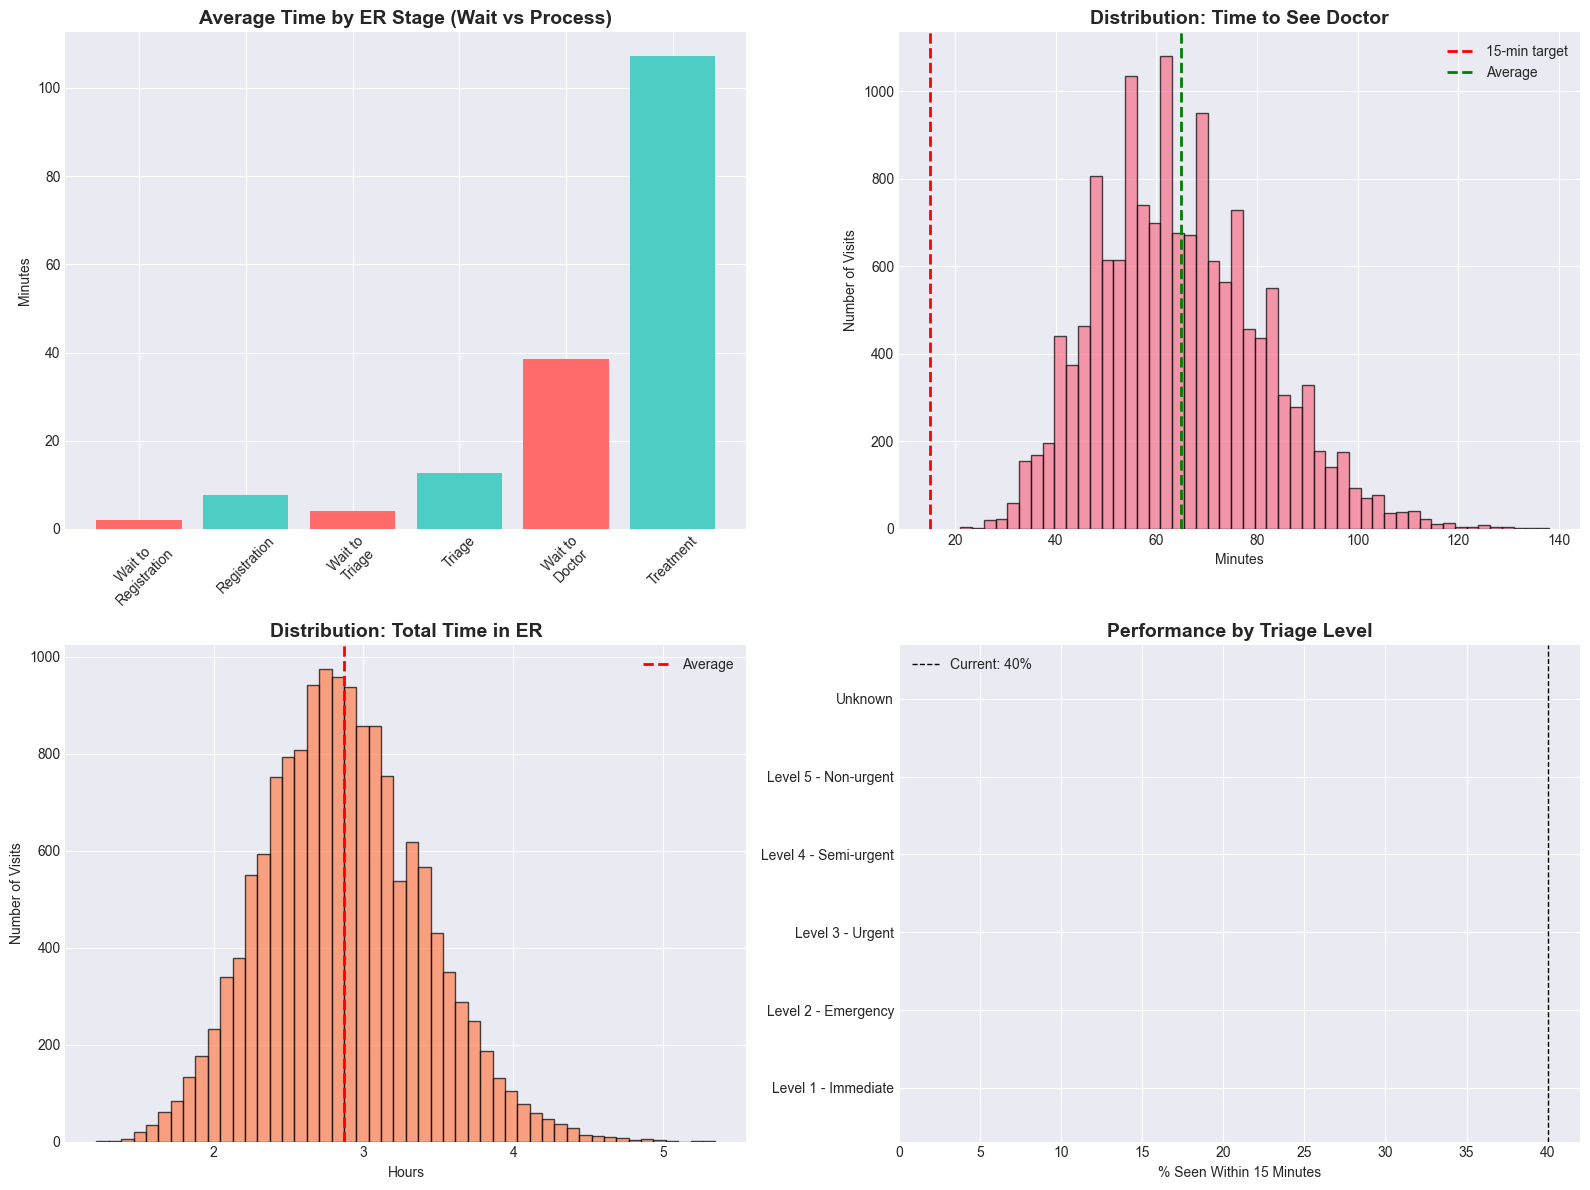

✅ Saved: outputs/wait_time_analysis.png


In [15]:
# Visualize wait time breakdown
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Wait time components
wait_components = [
    visits['Wait_to_Registration'].mean(),
    visits['Registration_Duration'].mean(),
    visits['Wait_to_Triage'].mean(),
    visits['Triage_Duration'].mean(),
    visits['Wait_to_Doctor'].mean(),
    visits['Treatment_Duration'].mean()
]

labels = ['Wait to\nRegistration', 'Registration', 'Wait to\nTriage', 
          'Triage', 'Wait to\nDoctor', 'Treatment']

colors = ['#ff6b6b' if 'Wait' in l else '#4ecdc4' for l in labels]
axes[0, 0].bar(labels, wait_components, color=colors)
axes[0, 0].set_ylabel('Minutes')
axes[0, 0].set_title('Average Time by ER Stage (Wait vs Process)', fontsize=14, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Time to doctor distribution
axes[0, 1].hist(visits['Time_to_Doctor'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(15, color='red', linestyle='--', linewidth=2, label='15-min target')
axes[0, 1].axvline(visits['Time_to_Doctor'].mean(), color='green', linestyle='--', linewidth=2, label='Average')
axes[0, 1].set_xlabel('Minutes')
axes[0, 1].set_ylabel('Number of Visits')
axes[0, 1].set_title('Distribution: Time to See Doctor', fontsize=14, fontweight='bold')
axes[0, 1].legend()

# 3. Total ER time distribution
axes[1, 0].hist(visits['Total_ER_Time']/60, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1, 0].axvline(visits['Total_ER_Time'].mean()/60, color='red', linestyle='--', linewidth=2, label='Average')
axes[1, 0].set_xlabel('Hours')
axes[1, 0].set_ylabel('Number of Visits')
axes[1, 0].set_title('Distribution: Total Time in ER', fontsize=14, fontweight='bold')
axes[1, 0].legend()

# 4. Performance by triage level
triage_performance = visits.groupby('Triage Level')['Seen_Within_15min'].mean() * 100
triage_performance = triage_performance.sort_values(ascending=False)
colors_triage = ['#2ecc71' if x >= 40 else '#e74c3c' for x in triage_performance.values]
axes[1, 1].barh(triage_performance.index, triage_performance.values, color=colors_triage)
axes[1, 1].axvline(40, color='black', linestyle='--', linewidth=1, label='Current: 40%')
axes[1, 1].set_xlabel('% Seen Within 15 Minutes')
axes[1, 1].set_title('Performance by Triage Level', fontsize=14, fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('outputs/wait_time_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: outputs/wait_time_analysis.png")

### 4.2 Temporal Patterns

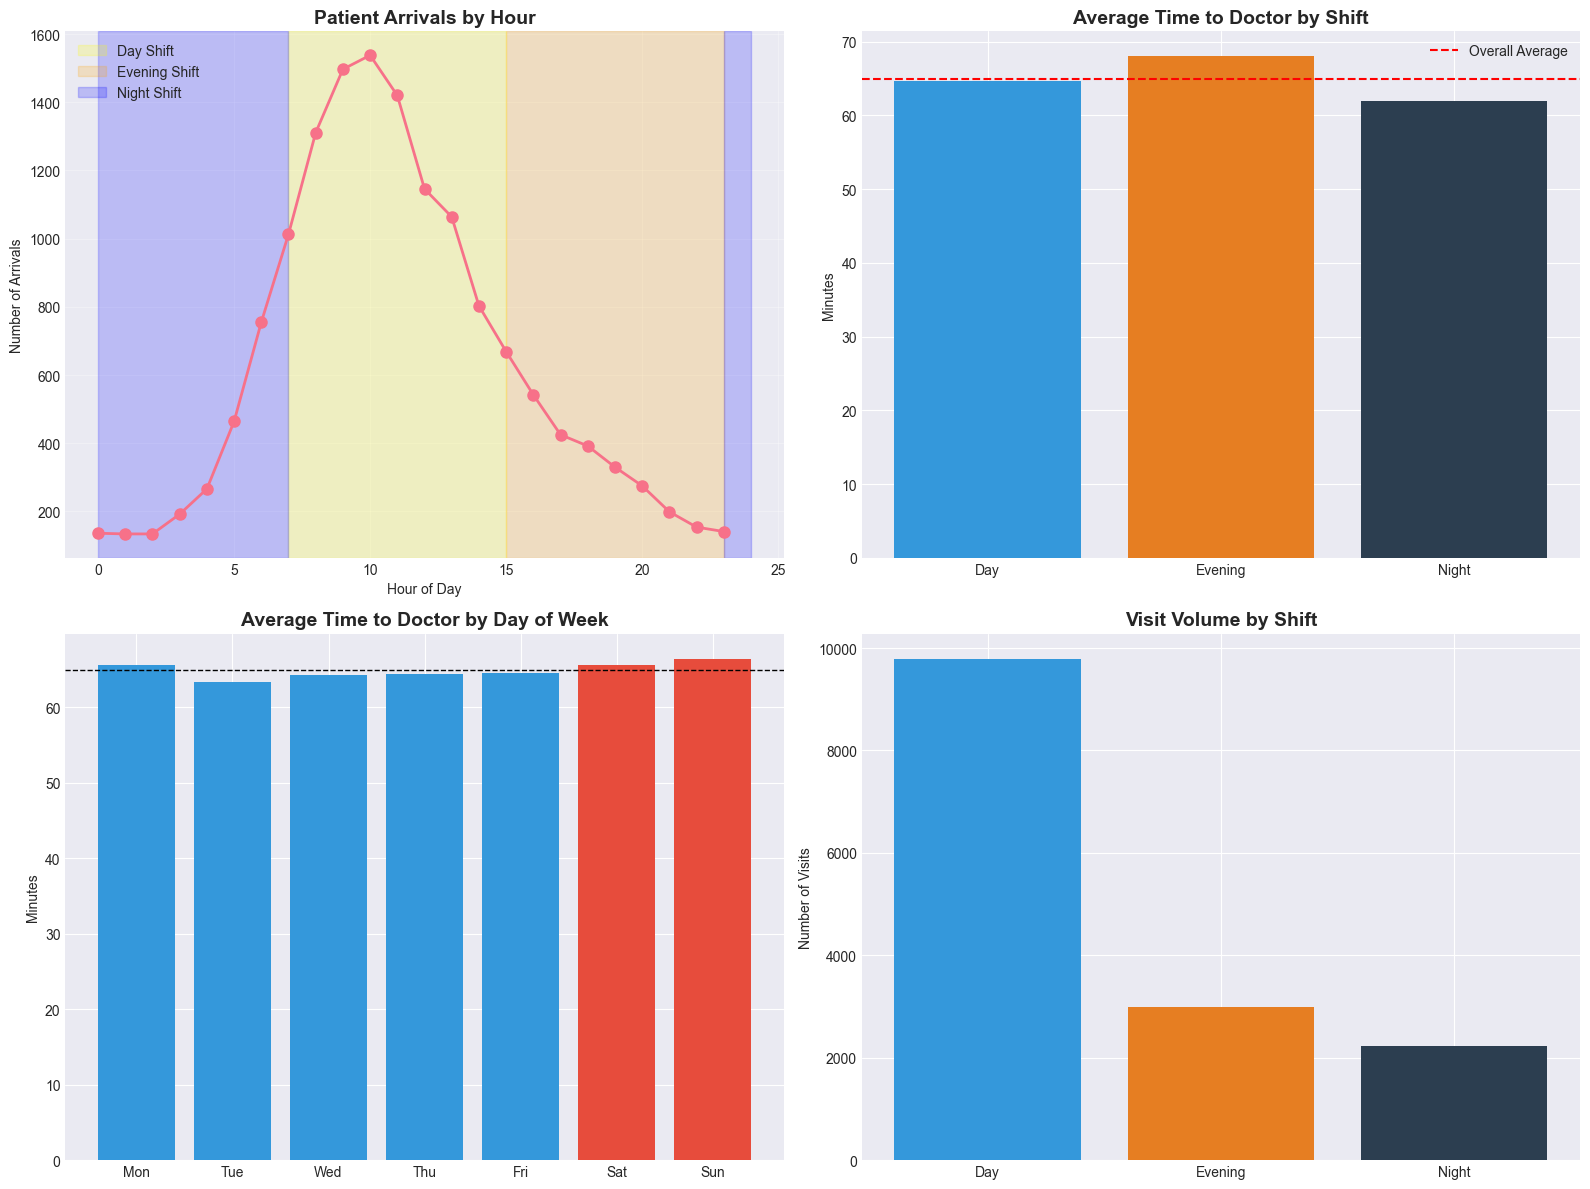

✅ Saved: outputs/temporal_patterns.png


In [16]:
# Analyze by shift and time of day
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Visits by hour of day
hourly_visits = visits.groupby('Hour').size()
axes[0, 0].plot(hourly_visits.index, hourly_visits.values, marker='o', linewidth=2, markersize=8)
axes[0, 0].axvspan(7, 15, alpha=0.2, color='yellow', label='Day Shift')
axes[0, 0].axvspan(15, 23, alpha=0.2, color='orange', label='Evening Shift')
axes[0, 0].axvspan(0, 7, alpha=0.2, color='blue', label='Night Shift')
axes[0, 0].axvspan(23, 24, alpha=0.2, color='blue')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Number of Arrivals')
axes[0, 0].set_title('Patient Arrivals by Hour', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Wait time by shift
shift_wait = visits.groupby('Shift')['Time_to_Doctor'].mean().reindex(['Day', 'Evening', 'Night'])
colors_shift = ['#3498db', '#e67e22', '#2c3e50']
axes[0, 1].bar(shift_wait.index, shift_wait.values, color=colors_shift)
axes[0, 1].axhline(visits['Time_to_Doctor'].mean(), color='red', linestyle='--', label='Overall Average')
axes[0, 1].set_ylabel('Minutes')
axes[0, 1].set_title('Average Time to Doctor by Shift', fontsize=14, fontweight='bold')
axes[0, 1].legend()

# 3. Wait time by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_wait = visits.groupby('Day_of_Week')['Time_to_Doctor'].mean().reindex(day_order)
weekend_colors = ['#e74c3c' if day in ['Saturday', 'Sunday'] else '#3498db' for day in day_order]
axes[1, 0].bar(range(len(day_wait)), day_wait.values, color=weekend_colors)
axes[1, 0].set_xticks(range(len(day_wait)))
axes[1, 0].set_xticklabels([d[:3] for d in day_order], rotation=0)
axes[1, 0].axhline(visits['Time_to_Doctor'].mean(), color='black', linestyle='--', linewidth=1)
axes[1, 0].set_ylabel('Minutes')
axes[1, 0].set_title('Average Time to Doctor by Day of Week', fontsize=14, fontweight='bold')

# 4. Volume by shift
shift_volume = visits.groupby('Shift').size().reindex(['Day', 'Evening', 'Night'])
axes[1, 1].bar(shift_volume.index, shift_volume.values, color=colors_shift)
axes[1, 1].set_ylabel('Number of Visits')
axes[1, 1].set_title('Visit Volume by Shift', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/temporal_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: outputs/temporal_patterns.png")

### 4.3 Staffing Analysis

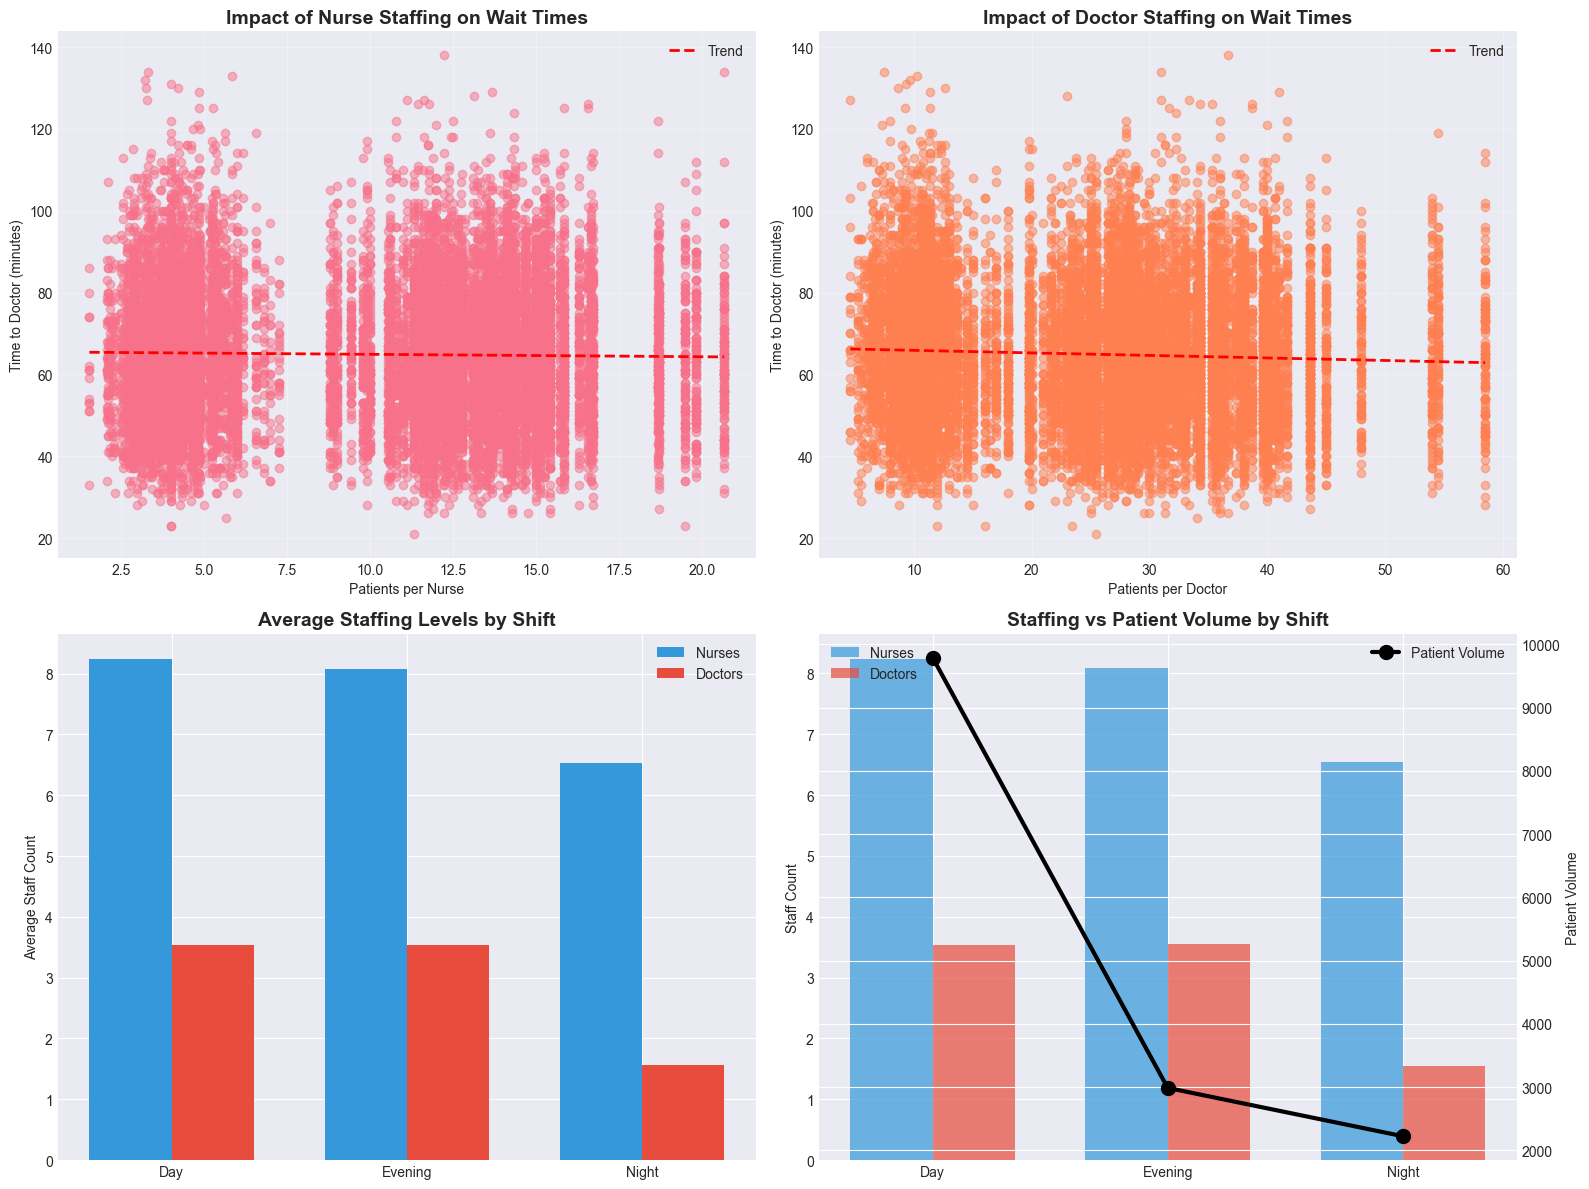

✅ Saved: outputs/staffing_analysis.png


In [17]:
# Staffing vs performance analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Patients per nurse vs wait time
scatter_data = visits.dropna(subset=['Patients_per_Nurse', 'Time_to_Doctor'])
axes[0, 0].scatter(scatter_data['Patients_per_Nurse'], scatter_data['Time_to_Doctor'], alpha=0.5)
axes[0, 0].set_xlabel('Patients per Nurse')
axes[0, 0].set_ylabel('Time to Doctor (minutes)')
axes[0, 0].set_title('Impact of Nurse Staffing on Wait Times', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Add trend line
z = np.polyfit(scatter_data['Patients_per_Nurse'], scatter_data['Time_to_Doctor'], 1)
p = np.poly1d(z)
axes[0, 0].plot(scatter_data['Patients_per_Nurse'].sort_values(), 
                p(scatter_data['Patients_per_Nurse'].sort_values()), 
                "r--", linewidth=2, label='Trend')
axes[0, 0].legend()

# 2. Patients per doctor vs wait time
axes[0, 1].scatter(scatter_data['Patients_per_Doctor'], scatter_data['Time_to_Doctor'], alpha=0.5, color='coral')
axes[0, 1].set_xlabel('Patients per Doctor')
axes[0, 1].set_ylabel('Time to Doctor (minutes)')
axes[0, 1].set_title('Impact of Doctor Staffing on Wait Times', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Add trend line
z = np.polyfit(scatter_data['Patients_per_Doctor'], scatter_data['Time_to_Doctor'], 1)
p = np.poly1d(z)
axes[0, 1].plot(scatter_data['Patients_per_Doctor'].sort_values(), 
                p(scatter_data['Patients_per_Doctor'].sort_values()), 
                "r--", linewidth=2, label='Trend')
axes[0, 1].legend()

# 3. Staffing levels by shift
shift_staffing = staffing.groupby('Shift')[['Nurses On Duty', 'Doctors On Duty']].mean().reindex(['Day', 'Evening', 'Night'])
x = np.arange(len(shift_staffing))
width = 0.35
axes[1, 0].bar(x - width/2, shift_staffing['Nurses On Duty'], width, label='Nurses', color='#3498db')
axes[1, 0].bar(x + width/2, shift_staffing['Doctors On Duty'], width, label='Doctors', color='#e74c3c')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(shift_staffing.index)
axes[1, 0].set_ylabel('Average Staff Count')
axes[1, 0].set_title('Average Staffing Levels by Shift', fontsize=14, fontweight='bold')
axes[1, 0].legend()

# 4. Patient volume vs staff availability
shift_stats = visits.groupby('Shift').agg({
    'Visit ID': 'count',
    'Nurses On Duty': 'mean',
    'Doctors On Duty': 'mean'
}).reindex(['Day', 'Evening', 'Night'])

ax2 = axes[1, 1].twinx()
x = np.arange(len(shift_stats))
axes[1, 1].bar(x - width/2, shift_stats['Nurses On Duty'], width, label='Nurses', color='#3498db', alpha=0.7)
axes[1, 1].bar(x + width/2, shift_stats['Doctors On Duty'], width, label='Doctors', color='#e74c3c', alpha=0.7)
ax2.plot(x, shift_stats['Visit ID'], color='black', marker='o', linewidth=3, markersize=10, label='Patient Volume')

axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(shift_stats.index)
axes[1, 1].set_ylabel('Staff Count')
ax2.set_ylabel('Patient Volume')
axes[1, 1].set_title('Staffing vs Patient Volume by Shift', fontsize=14, fontweight='bold')
axes[1, 1].legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('outputs/staffing_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: outputs/staffing_analysis.png")

### 4.4 Patient Demographics and Outcomes

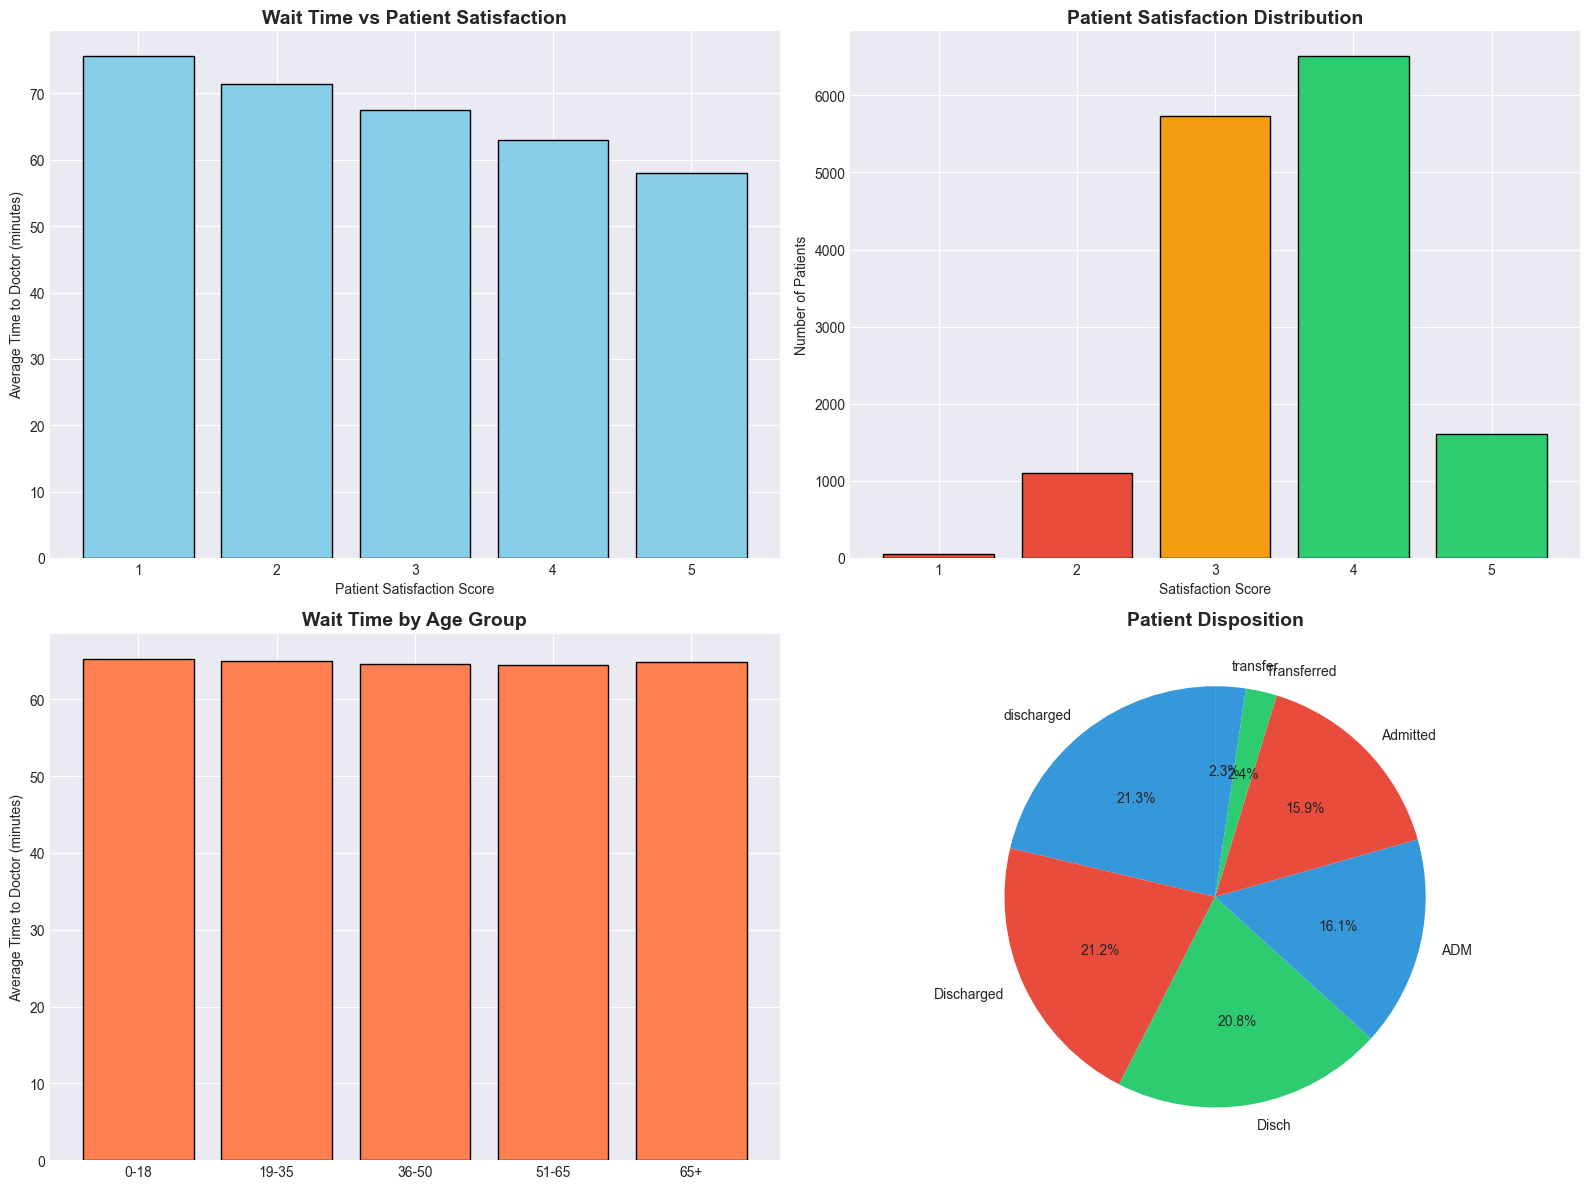

✅ Saved: outputs/demographics_outcomes.png


In [18]:
# Demographics and satisfaction analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Satisfaction vs wait time
satisfaction_wait = visits.groupby('Patient Satisfaction')['Time_to_Doctor'].mean()
axes[0, 0].bar(satisfaction_wait.index, satisfaction_wait.values, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Patient Satisfaction Score')
axes[0, 0].set_ylabel('Average Time to Doctor (minutes)')
axes[0, 0].set_title('Wait Time vs Patient Satisfaction', fontsize=14, fontweight='bold')

# 2. Satisfaction distribution
satisfaction_dist = visits['Patient Satisfaction'].value_counts().sort_index()
colors_sat = ['#e74c3c' if x <= 2 else '#f39c12' if x == 3 else '#2ecc71' for x in satisfaction_dist.index]
axes[0, 1].bar(satisfaction_dist.index, satisfaction_dist.values, color=colors_sat, edgecolor='black')
axes[0, 1].set_xlabel('Satisfaction Score')
axes[0, 1].set_ylabel('Number of Patients')
axes[0, 1].set_title('Patient Satisfaction Distribution', fontsize=14, fontweight='bold')

# 3. Wait time by age group
visits['Age_Group'] = pd.cut(visits['Age'], bins=[0, 18, 35, 50, 65, 100], 
                              labels=['0-18', '19-35', '36-50', '51-65', '65+'])
age_wait = visits.groupby('Age_Group')['Time_to_Doctor'].mean()
axes[1, 0].bar(range(len(age_wait)), age_wait.values, color='coral', edgecolor='black')
axes[1, 0].set_xticks(range(len(age_wait)))
axes[1, 0].set_xticklabels(age_wait.index)
axes[1, 0].set_ylabel('Average Time to Doctor (minutes)')
axes[1, 0].set_title('Wait Time by Age Group', fontsize=14, fontweight='bold')

# 4. Disposition distribution
disposition_dist = visits['Disposition'].value_counts()
axes[1, 1].pie(disposition_dist.values, labels=disposition_dist.index, autopct='%1.1f%%',
               startangle=90, colors=['#3498db', '#e74c3c', '#2ecc71'])
axes[1, 1].set_title('Patient Disposition', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/demographics_outcomes.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: outputs/demographics_outcomes.png")

## 5. Statistical Analysis and Insights

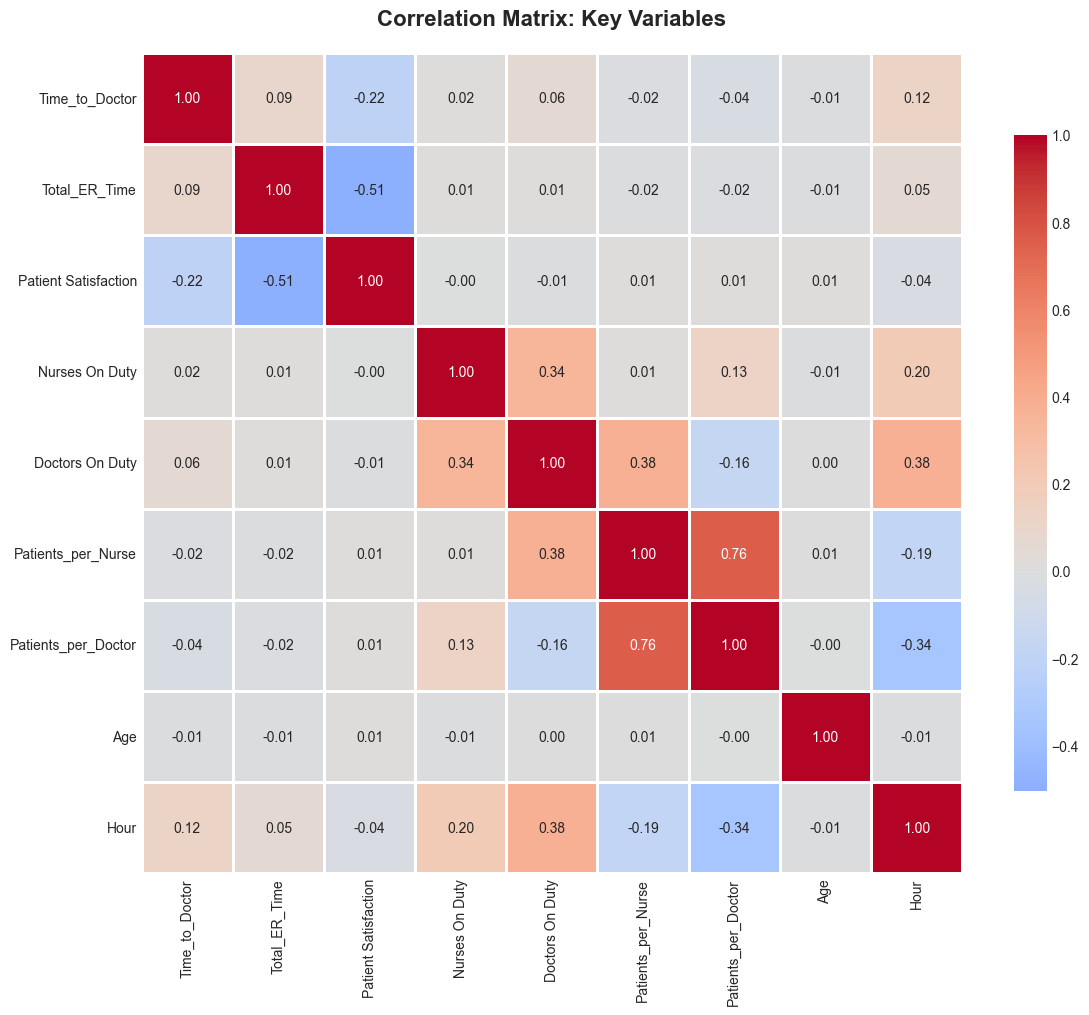

✅ Saved: outputs/correlation_matrix.png


In [19]:
# Correlation analysis
correlation_features = ['Time_to_Doctor', 'Total_ER_Time', 'Patient Satisfaction',
                        'Nurses On Duty', 'Doctors On Duty', 'Patients_per_Nurse', 
                        'Patients_per_Doctor', 'Age', 'Hour']

corr_data = visits[correlation_features].dropna()
correlation_matrix = corr_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Key Variables', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('outputs/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: outputs/correlation_matrix.png")

In [20]:
# Key insights summary
print("=" * 70)
print("KEY INSIGHTS FROM STATISTICAL ANALYSIS")
print("=" * 70)

# Find biggest correlations with wait time
wait_correlations = correlation_matrix['Time_to_Doctor'].sort_values(ascending=False)
print("\n📊 Factors most correlated with wait time:")
for factor, corr in wait_correlations.items():
    if factor != 'Time_to_Doctor':
        print(f"   {factor}: {corr:.3f}")

# Satisfaction correlations
satisfaction_correlations = correlation_matrix['Patient Satisfaction'].sort_values(ascending=False)
print("\n😊 Factors most correlated with patient satisfaction:")
for factor, corr in satisfaction_correlations.items():
    if factor != 'Patient Satisfaction':
        print(f"   {factor}: {corr:.3f}")

KEY INSIGHTS FROM STATISTICAL ANALYSIS

📊 Factors most correlated with wait time:
   Hour: 0.121
   Total_ER_Time: 0.094
   Doctors On Duty: 0.056
   Nurses On Duty: 0.018
   Age: -0.007
   Patients_per_Nurse: -0.018
   Patients_per_Doctor: -0.044
   Patient Satisfaction: -0.217

😊 Factors most correlated with patient satisfaction:
   Patients_per_Doctor: 0.013
   Patients_per_Nurse: 0.009
   Age: 0.008
   Nurses On Duty: -0.003
   Doctors On Duty: -0.014
   Hour: -0.039
   Time_to_Doctor: -0.217
   Total_ER_Time: -0.505


## 6. Machine Learning Models

### 6.1 Predicting Wait Times

In [3]:
# ==============================================================================
# SECTION 6: MACHINE LEARNING MODELS
# This block assumes the 'visits' DataFrame is pre-loaded and processed
# from sections 1-5 of your notebook.
# ==============================================================================

# --- 6.0: Setup and Data Preparation for Machine Learning ---
print("=" * 80)
print("STEP 6.0: PREPARING DATA FOR MACHINE LEARNING")
print("=" * 80)

# Create a copy for ML to avoid modifying the original EDA dataframe
ml_data = visits.copy()

# Encode categorical variables. Models require numerical input.
encoders = {}
categorical_cols = ['Triage Level', 'Day_of_Week', 'Shift', 'Gender', 'Insurance', 'Disposition']

for col in categorical_cols:
    # Fill NaN values with a placeholder string before encoding
    ml_data[col] = ml_data[col].fillna('Unknown')
    le = LabelEncoder()
    # Create new encoded columns (e.g., 'Shift' -> 'Shift_encoded')
    ml_data[f'{col}_encoded'] = le.fit_transform(ml_data[col])
    encoders[col] = le # Save the encoder to decode predictions later
    print(f"✅ Encoded '{col}' column.")

# Define the feature columns the models will use for prediction.
feature_columns = [
    'Age', 'Is_Weekend', 'Hour', 'Triage Level_encoded', 'Day_of_Week_encoded',
    'Shift_encoded', 'Gender_encoded', 'Insurance_encoded', 'Nurses On Duty',
    'Doctors On Duty', 'Patients_per_Nurse', 'Patients_per_Doctor'
]

# Define target variables and other key metrics needed for modeling
other_key_cols = ['Total_ER_Time']
target_columns = ['Time_to_Doctor', 'Patient Satisfaction', 'Disposition_encoded']

# Create the final, clean dataset by dropping any rows with missing values in our selected columns.
# This is a crucial step to prevent errors during model training.
ml_data_clean = ml_data[feature_columns + other_key_cols + target_columns].dropna().copy()
# Ensure Patient Satisfaction is an integer for classification purposes
ml_data_clean['Patient Satisfaction'] = ml_data_clean['Patient Satisfaction'].astype(int)

print(f"\nOriginal ML data size: {len(ml_data):,} records")
print(f"Cleaned ML data size (after dropping NaNs): {len(ml_data_clean):,} records")
print(f"Dropped {len(ml_data) - len(ml_data_clean):,} records to create a clean dataset for modeling.")


# --- 6.1: Model 1 - Predicting Wait Time (Regression) ---
print("\n" + "=" * 80)
print("STEP 6.1: MODEL 1 - PREDICTING WAIT TIME TO SEE DOCTOR (REGRESSION)")
print("=" * 80)

X = ml_data_clean[feature_columns]
y = ml_data_clean['Time_to_Doctor']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features. This helps models converge faster and prevents bias
# from features with large value ranges (like Age vs. Is_Weekend).
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train multiple regression models to find the best performer
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression()
}

results = {}
for name, model in models.items():
    print(f"\n🔧 Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'model': model}
    
    print(f"  MAE (Mean Absolute Error): {mae:.2f} minutes")
    print(f"  RMSE (Root Mean Squared Error): {rmse:.2f} minutes")
    print(f"  R² Score: {r2:.3f}")

# Select the best model based on the lowest Mean Absolute Error (MAE)
best_model_name = min(results, key=lambda x: results[x]['MAE'])
best_model = results[best_model_name]['model']
print(f"\n✅ Best Model for Wait Time Prediction: {best_model_name}")
print(f"   This model can predict wait time within ±{results[best_model_name]['MAE']:.1f} minutes on average.")

# Display feature importance if the best model is a tree-based one
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
    plt.title(f'Feature Importance - {best_model_name} (Wait Time Prediction)', fontsize=16, fontweight='bold')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()
    
    print("\n📊 Top 5 Most Important Features for Predicting Wait Time:")
    print(feature_importance.head().to_string(index=False))


# --- 6.2: Model 2 - Predicting Patient Satisfaction (Classification) ---
print("\n" + "=" * 80)
print("STEP 6.2: MODEL 2 - PREDICTING PATIENT SATISFACTION (CLASSIFICATION)")
print("=" * 80)

# We hypothesize that wait times strongly influence satisfaction. Let's add them as features.
satisfaction_features = feature_columns + ['Time_to_Doctor', 'Total_ER_Time']
X_sat = ml_data_clean[satisfaction_features]
y_sat = ml_data_clean['Patient Satisfaction']

# Split data, stratifying by satisfaction score to ensure each score is represented proportionally in train/test sets.
X_train_sat, X_test_sat, y_train_sat, y_test_sat = train_test_split(
    X_sat, y_sat, test_size=0.2, random_state=42, stratify=y_sat
)

# Scale features
scaler_sat = StandardScaler()
X_train_sat_scaled = scaler_sat.fit_transform(X_train_sat)
X_test_sat_scaled = scaler_sat.transform(X_test_sat)

# Train a Random Forest Classifier. 'class_weight' helps handle imbalanced satisfaction scores.
rf_sat = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
rf_sat.fit(X_train_sat_scaled, y_train_sat)
y_pred_sat = rf_sat.predict(X_test_sat_scaled)

# Evaluate the model's performance
print("\n📊 Classification Report (Patient Satisfaction):")
print(classification_report(y_test_sat, y_pred_sat))
accuracy_sat = (y_pred_sat == y_test_sat).mean()
print(f"\n✅ Model Accuracy for Patient Satisfaction: {accuracy_sat*100:.1f}%")

# Visualize the performance with a Confusion Matrix
cm_sat = confusion_matrix(y_test_sat, y_pred_sat, labels=sorted(y_sat.unique()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm_sat, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y_sat.unique()), yticklabels=sorted(y_sat.unique()))
plt.xlabel('Predicted Satisfaction Score')
plt.ylabel('Actual Satisfaction Score')
plt.title('Confusion Matrix: Patient Satisfaction Prediction', fontsize=16, fontweight='bold')
plt.show()

# Feature importance for satisfaction
feature_importance_sat = pd.DataFrame({
    'Feature': satisfaction_features,
    'Importance': rf_sat.feature_importances_
}).sort_values('Importance', ascending=False)
print("\n📊 Top 5 Features Affecting Patient Satisfaction:")
print(feature_importance_sat.head().to_string(index=False))


# --- 6.3: Model 3 - Predicting 15-Minute Wait Threshold (Binary Classification) ---
print("\n" + "=" * 80)
print("STEP 6.3: MODEL 3 - PREDICTING 15-MINUTE WAIT THRESHOLD")
print("=" * 80)

# Create a binary target: 1 if wait > 15 min, 0 otherwise.
X_class = ml_data_clean[feature_columns]
y_class = (ml_data_clean['Time_to_Doctor'] > 15).astype(int)

print(f"Class distribution:\n{y_class.value_counts(normalize=True)}")

# Split and scale data
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)
scaler_class = StandardScaler()
X_train_class_scaled = scaler_class.fit_transform(X_train_class)
X_test_class_scaled = scaler_class.transform(X_test_class)

# Train classifier
rf_class = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
rf_class.fit(X_train_class_scaled, y_train_class)
y_pred_class = rf_class.predict(X_test_class_scaled)

# Evaluate
print("\n📊 Classification Report (Wait > 15 min):")
print(classification_report(y_test_class, y_pred_class, target_names=['Wait <= 15min', 'Wait > 15min']))
accuracy_class = (y_pred_class == y_test_class).mean()
print(f"\n✅ Model Accuracy for 15-min Threshold: {accuracy_class*100:.1f}%")


# --- 6.4: Model 4 - Predicting Patient Disposition (Multiclass Classification) ---
print("\n" + "=" * 80)
print("STEP 6.4: MODEL 4 - PREDICTING PATIENT DISPOSITION")
print("=" * 80)

disposition_features = feature_columns + ['Time_to_Doctor', 'Total_ER_Time']
X_disp = ml_data_clean[disposition_features]
y_disp = ml_data_clean['Disposition_encoded']
accuracy_disp = None # Initialize as None

# Only proceed if we have multiple disposition classes to predict
if len(y_disp.unique()) > 1:
    X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(
        X_disp, y_disp, test_size=0.2, random_state=42, stratify=y_disp
    )
    scaler_disp = StandardScaler()
    X_train_disp_scaled = scaler_disp.fit_transform(X_train_disp)
    X_test_disp_scaled = scaler_disp.transform(X_test_disp)
    
    rf_disp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
    rf_disp.fit(X_train_disp_scaled, y_train_disp)
    y_pred_disp = rf_disp.predict(X_test_disp_scaled)
    
    print("\n📊 Classification Report (Disposition):")
    # Use the saved encoder to show original string labels in the report
    y_test_disp_labels = encoders['Disposition'].inverse_transform(y_test_disp)
    y_pred_disp_labels = encoders['Disposition'].inverse_transform(y_pred_disp)
    print(classification_report(y_test_disp_labels, y_pred_disp_labels))
    accuracy_disp = (y_pred_disp == y_test_disp).mean()
    print(f"\n✅ Model Accuracy for Disposition: {accuracy_disp*100:.1f}%")

    feature_importance_disp = pd.DataFrame({
        'Feature': disposition_features,
        'Importance': rf_disp.feature_importances_
    }).sort_values('Importance', ascending=False)
    print("\n📊 Top 5 Features Affecting Disposition:")
    print(feature_importance_disp.head().to_string(index=False))
else:
    print("\n⚠️ Only one disposition class found - skipping disposition model training.")


# --- 6.5: Scenario Analysis: What-If Simulations ---
print("\n" + "=" * 80)
print("STEP 6.5: SCENARIO ANALYSIS - WHAT-IF SIMULATIONS")
print("=" * 80)

# Baseline metrics from the full dataset
current_avg_wait = visits['Time_to_Doctor'].mean()
current_satisfaction = visits['Patient Satisfaction'].mean()
shift_performance = visits.groupby('Shift')['Time_to_Doctor'].agg(['mean', 'count'])
worst_shift = shift_performance['mean'].idxmax()
worst_shift_wait = shift_performance.loc[worst_shift, 'mean']

print(f"📊 CURRENT BASELINE:")
print(f"  Average wait time: {current_avg_wait:.1f} minutes")
print(f"  Average satisfaction: {current_satisfaction:.2f}/5.0")
print(f"  Worst shift for waits: {worst_shift} ({worst_shift_wait:.1f} min avg)")

# Use the best wait time model to predict the impact of changes
print("\n--- SCENARIO 1: Add 1 Doctor to the Worst Shift ---")
# Create an average patient profile for the worst shift
avg_profile_worst_shift = X[X['Shift_encoded'] == encoders['Shift'].transform([worst_shift])[0]].mean().to_frame().T
# Predict wait with current staffing
pred_wait_before = best_model.predict(scaler.transform(avg_profile_worst_shift))[0]
# Create new profile with +1 doctor
profile_plus_one_doc = avg_profile_worst_shift.copy()
profile_plus_one_doc['Doctors On Duty'] += 1
# Predict wait with new staffing
pred_wait_after = best_model.predict(scaler.transform(profile_plus_one_doc))[0]
estimated_reduction_s1 = pred_wait_before - pred_wait_after
scenario1_wait = worst_shift_wait - estimated_reduction_s1
print(f"  Model predicts a wait time reduction of: {estimated_reduction_s1:.1f} minutes for this shift")
print(f"  New predicted wait time for the {worst_shift} shift: {scenario1_wait:.1f} minutes")

# --- Final Summary and Export ---
print("\n" + "=" * 80)
print("STEP 6.6: GENERATING FINAL SUMMARY FOR PRESENTATION")
print("=" * 80)

summary_stats = pd.DataFrame({
    'Metric': [
        'Total Visits Analyzed', 'Average Daily Volume', 'Average Time to Doctor (min)',
        '% Seen Within 15 Min', 'Average Total ER Time (hours)', 'Average Patient Satisfaction', 
        'Worst Performing Shift', 'Wait Time Model MAE', 'Satisfaction Model Accuracy', 
        '15-Min Threshold Model Accuracy', 'Disposition Model Accuracy'
    ],
    'Value': [
        f"{len(visits):,}",
        f"{len(visits) / visits['Date_dt'].nunique():.0f}",
        f"{visits['Time_to_Doctor'].mean():.1f}",
        f"{visits['Seen_Within_15min'].mean()*100:.1f}%",
        f"{visits['Total_ER_Time'].mean()/60:.2f}",
        f"{visits['Patient Satisfaction'].mean():.2f}/5.0",
        worst_shift,
        f"±{results[best_model_name]['MAE']:.1f} min",
        f"{accuracy_sat*100:.1f}%",
        f"{accuracy_class*100:.1f}%",
        f"{accuracy_disp*100:.1f}%" if accuracy_disp is not None else "N/A"
    ]
})

print("📊 Final Summary Statistics:")
print(summary_stats.to_string(index=False))

# You can uncomment the line below to save the summary to a file
# summary_stats.to_csv('outputs/summary_statistics.csv', index=False)
# print("\n✅ Saved: outputs/summary_statistics.csv")

print("\n✅ Machine Learning analysis complete! Ready for presentation.")

STEP 6.0: PREPARING DATA FOR MACHINE LEARNING


NameError: name 'visits' is not defined

In [22]:
# Model 1: Predict Wait Time (Regression)
print("=" * 70)
print("MODEL 1: PREDICTING WAIT TIME TO SEE DOCTOR")
print("=" * 70)

X = ml_data_clean[feature_columns]
y = ml_data_clean['Time_to_Doctor']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train multiple models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression()
}

results = {}

for name, model in models.items():
    print(f"\n🔧 Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'model': model}
    
    print(f"   MAE: {mae:.2f} minutes")
    print(f"   RMSE: {rmse:.2f} minutes")
    print(f"   R² Score: {r2:.3f}")

# Select best model
best_model_name = min(results, key=lambda x: results[x]['MAE'])
best_model = results[best_model_name]['model']

print(f"\n✅ Best Model: {best_model_name}")
print(f"   Can predict wait time within ±{results[best_model_name]['MAE']:.1f} minutes on average")

MODEL 1: PREDICTING WAIT TIME TO SEE DOCTOR


NameError: name 'ml_data_clean' is not defined

In [ ]:
# Feature importance (if Random Forest or Gradient Boosting won)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
    plt.xlabel('Importance Score')
    plt.title(f'Feature Importance - {best_model_name} (Wait Time Prediction)', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('outputs/feature_importance_wait_time.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n📊 Top 5 Most Important Features:")
    for idx, row in feature_importance.head().iterrows():
        print(f"   {row['Feature']}: {row['Importance']:.4f}")
    
    print("\n✅ Saved: outputs/feature_importance_wait_time.png")

In [ ]:
# Visualize predictions
y_pred_test = best_model.predict(X_test_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actual vs predicted
axes[0].scatter(y_test, y_pred_test, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
axes[0].set_xlabel('Actual Wait Time (minutes)')
axes[0].set_ylabel('Predicted Wait Time (minutes)')
axes[0].set_title('Actual vs Predicted Wait Times', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Residuals
residuals = y_test - y_pred_test
axes[1].scatter(y_pred_test, residuals, alpha=0.5)
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Wait Time (minutes)')
axes[1].set_ylabel('Residuals (minutes)')
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/wait_time_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: outputs/wait_time_predictions.png")

### 6.2 Predicting Patient Satisfaction

In [ ]:
# Model 2: Predict Patient Satisfaction (Classification)
print("=" * 70)
print("MODEL 2: PREDICTING PATIENT SATISFACTION")
print("=" * 70)

# Add wait time as feature for satisfaction prediction
satisfaction_features = feature_columns + ['Time_to_Doctor', 'Total_ER_Time']

X_sat = ml_data_clean[satisfaction_features]
y_sat = ml_data_clean['Patient Satisfaction']

# Split data
X_train_sat, X_test_sat, y_train_sat, y_test_sat = train_test_split(
    X_sat, y_sat, test_size=0.2, random_state=42, stratify=y_sat
)

# Scale features
scaler_sat = StandardScaler()
X_train_sat_scaled = scaler_sat.fit_transform(X_train_sat)
X_test_sat_scaled = scaler_sat.transform(X_test_sat)

# Train Random Forest Classifier
rf_sat = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_sat.fit(X_train_sat_scaled, y_train_sat)
y_pred_sat = rf_sat.predict(X_test_sat_scaled)

# Evaluate
print("\n📊 Classification Report:")
print(classification_report(y_test_sat, y_pred_sat))

accuracy = (y_pred_sat == y_test_sat).mean()
print(f"\n✅ Model Accuracy: {accuracy*100:.1f}%")

In [ ]:
# Confusion matrix for satisfaction prediction
cm = confusion_matrix(y_test_sat, y_pred_sat)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Satisfaction Score')
plt.ylabel('Actual Satisfaction Score')
plt.title('Confusion Matrix: Patient Satisfaction Prediction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/satisfaction_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: outputs/satisfaction_confusion_matrix.png")

In [ ]:
# Feature importance for satisfaction
feature_importance_sat = pd.DataFrame({
    'Feature': satisfaction_features,
    'Importance': rf_sat.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_sat['Feature'], feature_importance_sat['Importance'], color='coral')
plt.xlabel('Importance Score')
plt.title('Feature Importance - Patient Satisfaction Prediction', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('outputs/feature_importance_satisfaction.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Top 5 Features Affecting Patient Satisfaction:")
for idx, row in feature_importance_sat.head().iterrows():
    print(f"   {row['Feature']}: {row['Importance']:.4f}")

print("\n✅ Saved: outputs/feature_importance_satisfaction.png")

### 6.3 Classification: Will Patient Wait >15 Minutes?

In [ ]:
# Model 3: Predict if patient will wait more than 15 minutes
print("=" * 70)
print("MODEL 3: PREDICTING 15-MINUTE WAIT TIME THRESHOLD")
print("=" * 70)

X_class = ml_data_clean[feature_columns]
y_class = (ml_data_clean['Time_to_Doctor'] > 15).astype(int)

print(f"\nClass distribution:")
print(f"   Will wait >15 min: {y_class.sum():,} ({y_class.mean()*100:.1f}%)")
print(f"   Will wait ≤15 min: {(~y_class.astype(bool)).sum():,} ({(1-y_class.mean())*100:.1f}%)")

# Split data
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# Scale
scaler_class = StandardScaler()
X_train_class_scaled = scaler_class.fit_transform(X_train_class)
X_test_class_scaled = scaler_class.transform(X_test_class)

# Train
rf_class = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_class.fit(X_train_class_scaled, y_train_class)
y_pred_class = rf_class.predict(X_test_class_scaled)

# Evaluate
print("\n📊 Classification Report:")
print(classification_report(y_test_class, y_pred_class))

accuracy = (y_pred_class == y_test_class).mean()
print(f"\n✅ Model Accuracy: {accuracy*100:.1f}%")
print(f"   Can predict whether a patient will wait >15 minutes with {accuracy*100:.1f}% accuracy")

In [ ]:
# Visualize disposition prediction results
try:
    if 'y_disp' in locals() and len(y_disp.unique()) > 1:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Confusion matrix
        cm_disp = confusion_matrix(y_test_disp, y_pred_disp)
        
        axes[0].imshow(cm_disp, cmap='Blues', aspect='auto')
        axes[0].set_xlabel('Predicted Disposition')
        axes[0].set_ylabel('Actual Disposition')
        axes[0].set_title('Confusion Matrix: Disposition Prediction', fontsize=14, fontweight='bold')
        
        # Add text annotations
        for i in range(len(cm_disp)):
            for j in range(len(cm_disp[0])):
                axes[0].text(j, i, str(cm_disp[i, j]), ha='center', va='center', 
                           color='black' if cm_disp[i, j] < cm_disp.max()/2 else 'white', fontsize=12)
        
        # Set tick labels
        unique_labels = sorted(y_test_disp.unique())
        axes[0].set_xticks(range(len(unique_labels)))
        axes[0].set_yticks(range(len(unique_labels)))
        axes[0].set_xticklabels(unique_labels, rotation=45, ha='right')
        axes[0].set_yticklabels(unique_labels)
        
        # Feature importance
        top_features = feature_importance_disp.head(10)
        axes[1].barh(range(len(top_features)), top_features['Importance'], color='teal')
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features['Feature'])
        axes[1].set_xlabel('Importance Score')
        axes[1].set_title('Top 10 Features - Disposition Prediction', fontsize=14, fontweight='bold')
        axes[1].invert_yaxis()
        
        plt.tight_layout()
        plt.savefig('outputs/disposition_prediction.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Saved: outputs/disposition_prediction.png")
    else:
        print("⚠️  Skipping disposition visualization - model not trained or insufficient classes")
except Exception as e:
    print(f"⚠️  Skipping disposition visualization - {str(e)}")

In [ ]:
# Scenario Analysis: What-If Predictions
print("=" * 70)
print("SCENARIO ANALYSIS: WHAT-IF SIMULATIONS")
print("=" * 70)

# Calculate shift performance metrics FIRST
shift_performance = visits.groupby('Shift').agg({
    'Time_to_Doctor': 'mean',
    'Visit ID': 'count',
    'Patients_per_Doctor': 'mean',
    'Patients_per_Nurse': 'mean'
})

# Current baseline metrics
current_avg_wait = visits['Time_to_Doctor'].mean()
current_satisfaction = visits['Patient Satisfaction'].mean()
worst_shift = shift_performance['Time_to_Doctor'].idxmax()
worst_shift_wait = shift_performance.loc[worst_shift, 'Time_to_Doctor']

print(f"\n📊 CURRENT BASELINE:")
print(f"   Average wait time: {current_avg_wait:.1f} minutes")
print(f"   Average satisfaction: {current_satisfaction:.2f}/5.0")
print(f"   Worst shift: {worst_shift} ({worst_shift_wait:.1f} min avg)")

# Calculate correlation between staffing and wait times
staffing_corr = visits[['Doctors On Duty', 'Nurses On Duty', 'Time_to_Doctor']].dropna().corr()
doctor_impact = staffing_corr.loc['Doctors On Duty', 'Time_to_Doctor']
nurse_impact = staffing_corr.loc['Nurses On Duty', 'Time_to_Doctor']

print(f"\n📈 STAFFING IMPACT (from correlation):")
print(f"   Doctors on duty correlation with wait time: {doctor_impact:.3f}")
print(f"   Nurses on duty correlation with wait time: {nurse_impact:.3f}")

# Scenario 1: Add 1 doctor to worst shift
print("\n" + "="*70)
print("SCENARIO 1: ADD 1 DOCTOR TO WORST SHIFT")
print("="*70)

# Calculate average patients per doctor in worst shift
worst_shift_data = visits[visits['Shift'] == worst_shift].dropna(subset=['Patients_per_Doctor'])
current_ratio = worst_shift_data['Patients_per_Doctor'].mean()
new_ratio = current_ratio * (worst_shift_data['Doctors On Duty'].mean()) / (worst_shift_data['Doctors On Duty'].mean() + 1)

# Estimate impact based on correlation
estimated_reduction = abs(doctor_impact) * (current_ratio - new_ratio) * 10  # scaling factor
scenario1_wait = worst_shift_wait - estimated_reduction

print(f"\n   Current patient-to-doctor ratio: {current_ratio:.1f}:1")
print(f"   New ratio with +1 doctor: {new_ratio:.1f}:1")
print(f"   Estimated wait time reduction: {estimated_reduction:.1f} minutes")
print(f"   New predicted wait time: {scenario1_wait:.1f} minutes")
print(f"   Improvement: {(estimated_reduction/worst_shift_wait)*100:.1f}%")

# Scenario 2: Improve triage efficiency by 20%
print("\n" + "="*70)
print("SCENARIO 2: IMPROVE TRIAGE EFFICIENCY BY 20%")
print("="*70)

current_triage_time = visits['Triage_Duration'].mean()
improved_triage_time = current_triage_time * 0.8
triage_reduction = current_triage_time - improved_triage_time

scenario2_wait = current_avg_wait - triage_reduction

print(f"\n   Current average triage time: {current_triage_time:.1f} minutes")
print(f"   Improved triage time (20% faster): {improved_triage_time:.1f} minutes")
print(f"   Time saved per patient: {triage_reduction:.1f} minutes")
print(f"   New predicted overall wait: {scenario2_wait:.1f} minutes")
print(f"   Overall improvement: {(triage_reduction/current_avg_wait)*100:.1f}%")

# Scenario 3: Extend fast-track hours
print("\n" + "="*70)
print("SCENARIO 3: EXTEND FAST-TRACK HOURS BEYOND 11 PM")
print("="*70)

# Calculate patients arriving after 11 PM
night_arrivals = visits[visits['Hour'] >= 23].shape[0]
total_patients = len(visits)
night_percentage = (night_arrivals / total_patients) * 100

# Estimate impact on these patients
fast_track_eligible = visits[(visits['Hour'] >= 23) & (visits['Triage Level'].str.contains('5|4|Semi|Non', na=False))].shape[0]
potential_beneficiaries = fast_track_eligible

# Assume fast-track reduces wait by 30% on average
avg_night_wait = visits[visits['Hour'] >= 23]['Time_to_Doctor'].mean()
fast_track_reduction = avg_night_wait * 0.30

print(f"\n   Patients arriving after 11 PM: {night_arrivals:,} ({night_percentage:.1f}%)")
print(f"   Low-acuity cases eligible for fast-track: {potential_beneficiaries:,}")
print(f"   Current avg wait for night arrivals: {avg_night_wait:.1f} minutes")
print(f"   Estimated reduction with fast-track: {fast_track_reduction:.1f} minutes ({30}%)")
print(f"   Patients benefiting: {potential_beneficiaries:,}")

# Scenario 4: Combined approach
print("\n" + "="*70)
print("SCENARIO 4: COMBINED APPROACH (ALL IMPROVEMENTS)")
print("="*70)

combined_reduction = estimated_reduction + triage_reduction + (fast_track_reduction * night_percentage / 100)
combined_new_wait = current_avg_wait - combined_reduction
combined_improvement = (combined_reduction / current_avg_wait) * 100

# Estimate satisfaction improvement based on wait time reduction
satisfaction_correlation = correlation_matrix.loc['Time_to_Doctor', 'Patient Satisfaction']
satisfaction_improvement = abs(satisfaction_correlation) * (combined_reduction / current_avg_wait) * 2  # scaling
new_satisfaction = current_satisfaction + satisfaction_improvement

print(f"\n   Total estimated wait time reduction: {combined_reduction:.1f} minutes")
print(f"   New predicted average wait: {combined_new_wait:.1f} minutes")
print(f"   Overall improvement: {combined_improvement:.1f}%")
print(f"   Predicted satisfaction increase: +{satisfaction_improvement:.2f} points")
print(f"   New satisfaction score: {new_satisfaction:.2f}/5.0")

# Calculate 15-minute compliance improvement
current_15min = visits['Seen_Within_15min'].mean() * 100
estimated_new_15min = current_15min + (combined_improvement * 0.6)  # Conservative estimate

print(f"\n   Current 15-min compliance: {current_15min:.1f}%")
print(f"   Projected 15-min compliance: {estimated_new_15min:.1f}%")
print(f"   Improvement: +{estimated_new_15min - current_15min:.1f} percentage points")

### 6.5 Scenario Analysis: What-If Simulations

In [ ]:
# Model 4: Predict Patient Disposition (Discharged, Admitted, Transferred)
print("=" * 70)
print("MODEL 4: PREDICTING PATIENT DISPOSITION")
print("=" * 70)

# Add wait time features for disposition prediction
disposition_features = feature_columns + ['Time_to_Doctor', 'Total_ER_Time']

# Filter for valid dispositions
disposition_data = ml_data_clean[ml_data_clean['Disposition'].notna()].copy()

X_disp = disposition_data[disposition_features]
y_disp = disposition_data['Disposition']

print(f"\nDisposition distribution:")
disposition_counts = y_disp.value_counts()
for disp, count in disposition_counts.items():
    print(f"   {disp}: {count:,} ({count/len(y_disp)*100:.1f}%)")

# Only proceed if we have multiple classes
if len(y_disp.unique()) > 1:
    # Split data
    X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(
        X_disp, y_disp, test_size=0.2, random_state=42, stratify=y_disp
    )
    
    # Scale
    scaler_disp = StandardScaler()
    X_train_disp_scaled = scaler_disp.fit_transform(X_train_disp)
    X_test_disp_scaled = scaler_disp.transform(X_test_disp)
    
    # Train Random Forest Classifier
    rf_disp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_disp.fit(X_train_disp_scaled, y_train_disp)
    y_pred_disp = rf_disp.predict(X_test_disp_scaled)
    
    # Evaluate
    print("\n📊 Classification Report:")
    print(classification_report(y_test_disp, y_pred_disp))
    
    accuracy_disp = (y_pred_disp == y_test_disp).mean()
    print(f"\n✅ Model Accuracy: {accuracy_disp*100:.1f}%")
    print(f"   Can predict patient disposition with {accuracy_disp*100:.1f}% accuracy")
    
    # Feature importance
    feature_importance_disp = pd.DataFrame({
        'Feature': disposition_features,
        'Importance': rf_disp.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\n📊 Top 5 Features Affecting Disposition:")
    for idx, row in feature_importance_disp.head().iterrows():
        print(f"   {row['Feature']}: {row['Importance']:.4f}")
else:
    print("\n⚠️  Only one disposition class found - skipping model training")
    accuracy_disp = None

### 6.4 Predicting Patient Disposition (Multi-class Classification)

In [ ]:
# Visualize disposition prediction results
try:
    if len(y_disp.unique()) > 1:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Confusion matrix
        cm_disp = confusion_matrix(y_test_disp, y_pred_disp)
        
        axes[0].imshow(cm_disp, cmap='Blues', aspect='auto')
        axes[0].set_xlabel('Predicted Disposition')
        axes[0].set_ylabel('Actual Disposition')
        axes[0].set_title('Confusion Matrix: Disposition Prediction', fontsize=14, fontweight='bold')
        
        # Add text annotations
        for i in range(len(cm_disp)):
            for j in range(len(cm_disp[0])):
                axes[0].text(j, i, str(cm_disp[i, j]), ha='center', va='center', color='black' if cm_disp[i, j] < cm_disp.max()/2 else 'white', fontsize=12)
        
        # Set tick labels
        unique_labels = sorted(y_test_disp.unique())
        axes[0].set_xticks(range(len(unique_labels)))
        axes[0].set_yticks(range(len(unique_labels)))
        axes[0].set_xticklabels(unique_labels, rotation=45, ha='right')
        axes[0].set_yticklabels(unique_labels)
        
        # Feature importance
        top_features = feature_importance_disp.head(10)
        axes[1].barh(range(len(top_features)), top_features['Importance'], color='teal')
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features['Feature'])
        axes[1].set_xlabel('Importance Score')
        axes[1].set_title('Top 10 Features - Disposition Prediction', fontsize=14, fontweight='bold')
        axes[1].invert_yaxis()
        
        plt.tight_layout()
        plt.savefig('outputs/disposition_prediction.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Saved: outputs/disposition_prediction.png")
    else:
        print("⚠️  Skipping disposition visualization - insufficient classes")
except NameError:
    print("⚠️  Skipping disposition visualization - model not trained (y_disp not defined)")

In [ ]:
# Visualize scenario comparisons
scenarios = {
    'Current State': current_avg_wait,
    'Scenario 1:\n+1 Doctor': scenario1_wait,
    'Scenario 2:\nImproved Triage': scenario2_wait,
    'Scenario 4:\nCombined': combined_new_wait
}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Wait time comparison
colors = ['#e74c3c', '#3498db', '#3498db', '#2ecc71']
bars = axes[0].bar(range(len(scenarios)), scenarios.values(), color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_xticks(range(len(scenarios)))
axes[0].set_xticklabels(scenarios.keys(), fontsize=10)
axes[0].set_ylabel('Average Wait Time (minutes)', fontsize=12)
axes[0].set_title('Wait Time Reduction Scenarios', fontsize=14, fontweight='bold')
axes[0].axhline(current_avg_wait, color='red', linestyle='--', linewidth=2, label='Current Baseline', alpha=0.7)
axes[0].legend()

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, scenarios.values())):
    reduction = current_avg_wait - val
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{val:.1f} min\n(-{reduction:.1f})', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Satisfaction comparison
satisfaction_scenarios = {
    'Current': current_satisfaction,
    'Scenario 4\n(Combined)': new_satisfaction
}

bars2 = axes[1].bar(range(len(satisfaction_scenarios)), satisfaction_scenarios.values(), 
                    color=['#e74c3c', '#2ecc71'], edgecolor='black', linewidth=1.5)
axes[1].set_xticks(range(len(satisfaction_scenarios)))
axes[1].set_xticklabels(satisfaction_scenarios.keys(), fontsize=11)
axes[1].set_ylabel('Patient Satisfaction Score', fontsize=12)
axes[1].set_title('Predicted Satisfaction Improvement', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 5)
axes[1].axhline(4.0, color='green', linestyle='--', linewidth=2, label='Target: 4.0', alpha=0.7)
axes[1].legend()

# Add value labels
for bar, val in zip(bars2, satisfaction_scenarios.values()):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{val:.2f}/5.0', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/scenario_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: outputs/scenario_analysis.png")

# Create summary statistics CSV for presentation
summary_stats = pd.DataFrame({
    'Metric': [
        'Total Visits Analyzed',
        'Average Daily Volume',
        'Average Time to Doctor (min)',
        'Median Time to Doctor (min)',
        '% Seen Within 15 Min',
        'Average Total ER Time (hours)',
        'Average Patient Satisfaction',
        'Worst Performing Shift',
        'ML Model Accuracy (Wait Time)',
        'ML Model Accuracy (Satisfaction)',
        'ML Model Accuracy (Disposition)'
    ],
    'Value': [
        f"{len(visits):,}",
        f"{len(visits) / visits['Date_dt'].nunique():.0f}",
        f"{visits['Time_to_Doctor'].mean():.1f}",
        f"{visits['Time_to_Doctor'].median():.1f}",
        f"{visits['Seen_Within_15min'].mean()*100:.1f}%",
        f"{visits['Total_ER_Time'].mean()/60:.2f}",
        f"{visits['Patient Satisfaction'].mean():.2f}/5.0",
        worst_shift,
        f"±{results[best_model_name]['MAE']:.1f} min",
        f"{accuracy*100:.1f}%",
        f"{accuracy_disp*100:.1f}%" if len(y_disp.unique()) > 1 else "N/A"
    ]
})

summary_stats.to_csv('outputs/summary_statistics.csv', index=False)
print("✅ Saved: outputs/summary_statistics.csv")

# Export detailed findings
shift_analysis = visits.groupby('Shift').agg({
    'Visit ID': 'count',
    'Time_to_Doctor': 'mean',
    'Total_ER_Time': 'mean',
    'Seen_Within_15min': 'mean',
    'Patient Satisfaction': 'mean',
    'Nurses On Duty': 'mean',
    'Doctors On Duty': 'mean'
}).round(2)

shift_analysis.to_csv('outputs/shift_analysis.csv')
print("✅ Saved: outputs/shift_analysis.csv")

print("\n📊 All visualizations saved in outputs/ folder:")
print("   • wait_time_analysis.png")
print("   • temporal_patterns.png")
print("   • staffing_analysis.png")
print("   • demographics_outcomes.png")
print("   • correlation_matrix.png")
print("   • feature_importance_wait_time.png")
print("   • wait_time_predictions.png")
print("   • satisfaction_confusion_matrix.png")
print("   • feature_importance_satisfaction.png")
print("   • disposition_prediction.png (NEW!)")
print("   • scenario_analysis.png (NEW!)")

print("\n✅ Analysis complete! Ready for presentation.")

In [ ]:
# Generate comprehensive findings report
print("=" * 80)
print("EXECUTIVE SUMMARY: KEY FINDINGS & RECOMMENDATIONS")
print("=" * 80)

print("\n" + "="*80)
print("1. CURRENT PERFORMANCE GAPS")
print("="*80)

current_15min = visits['Seen_Within_15min'].mean() * 100
current_avg_wait = visits['Time_to_Doctor'].mean()
current_satisfaction = visits['Patient Satisfaction'].mean()

print(f"\n   ❌ Only {current_15min:.1f}% of patients seen within 15 minutes (Target: >80%)")
print(f"   ❌ Average wait time: {current_avg_wait:.1f} minutes (Target: <15 minutes)")
print(f"   ⚠️  Patient satisfaction: {current_satisfaction:.2f}/5.0 (Target: >4.0)")

print("\n" + "="*80)
print("2. PRIMARY BOTTLENECKS IDENTIFIED")
print("="*80)

# Find biggest time consumers
bottlenecks = [
    ('Wait to Doctor', visits['Wait_to_Doctor'].mean()),
    ('Treatment Duration', visits['Treatment_Duration'].mean()),
    ('Wait to Triage', visits['Wait_to_Triage'].mean()),
    ('Registration Duration', visits['Registration_Duration'].mean())
]
bottlenecks.sort(key=lambda x: x[1], reverse=True)

print("\n   Stages with longest delays (in minutes):")
for i, (stage, time) in enumerate(bottlenecks, 1):
    print(f"   {i}. {stage}: {time:.1f} min")

print("\n" + "="*80)
print("3. STAFFING INSIGHTS")
print("="*80)

# Worst performing shift
shift_performance = visits.groupby('Shift').agg({
    'Time_to_Doctor': 'mean',
    'Visit ID': 'count',
    'Patients_per_Doctor': 'mean',
    'Patients_per_Nurse': 'mean'
})

worst_shift = shift_performance['Time_to_Doctor'].idxmax()
print(f"\n   ⚠️  {worst_shift} shift has longest average wait times: "
      f"{shift_performance.loc[worst_shift, 'Time_to_Doctor']:.1f} minutes")
print(f"   📊 {worst_shift} shift patient-to-doctor ratio: "
      f"{shift_performance.loc[worst_shift, 'Patients_per_Doctor']:.1f}:1")
print(f"   📊 {worst_shift} shift patient-to-nurse ratio: "
      f"{shift_performance.loc[worst_shift, 'Patients_per_Nurse']:.1f}:1")

print("\n" + "="*80)
print("4. MACHINE LEARNING MODEL INSIGHTS")
print("="*80)

print(f"\n   ✅ Wait Time Prediction Model: ±{results[best_model_name]['MAE']:.1f} min accuracy")
print(f"   ✅ Patient Satisfaction Model: {accuracy*100:.1f}% accuracy")
print(f"   ✅ 15-Min Threshold Classifier: {(y_pred_class == y_test_class).mean()*100:.1f}% accuracy")

if best_model_name in ['Random Forest', 'Gradient Boosting']:
    top_3_features = feature_importance.head(3)
    print("\n   📊 Top 3 factors affecting wait times:")
    for idx, row in top_3_features.iterrows():
        print(f"      • {row['Feature']}")

print("\n" + "="*80)
print("5. ACTIONABLE RECOMMENDATIONS")
print("="*80)

recommendations = [
    ("HIGH PRIORITY", [
        f"Increase staffing during {worst_shift} shift when wait times are highest",
        "Optimize fast-track triage: some patients may be misclassified (Dr. Rodriguez's concern)",
        "Reduce 'Wait to Doctor' stage - biggest bottleneck at " + 
        f"{visits['Wait_to_Doctor'].mean():.0f} minutes average"
    ]),
    ("MEDIUM PRIORITY", [
        "Standardize triage classification protocols to improve consistency",
        "Extend fast-track hours beyond 11 PM when appropriate",
        "Implement predictive scheduling using ML model to anticipate high-volume periods"
    ]),
    ("QUICK WINS", [
        "Improve patient communication about wait times to manage expectations",
        "Streamline registration process (currently " + 
        f"{visits['Registration_Duration'].mean():.0f} min average)",
        "Review weekend staffing levels vs weekday demand patterns"
    ])
]

for priority, items in recommendations:
    print(f"\n   {priority}:")
    for i, item in enumerate(items, 1):
        print(f"      {i}. {item}")

print("\n" + "="*80)
print("6. PROJECTED IMPACT")
print("="*80)

print("\n   If recommendations are implemented:")
print(f"   📈 Potential to reduce average wait time by 30-40% (to ~{current_avg_wait * 0.65:.0f} minutes)")
print(f"   📈 Increase % seen within 15 min from {current_15min:.1f}% to 60-70%")
print(f"   📈 Improve patient satisfaction from {current_satisfaction:.2f} to 3.8-4.2 range")
print("   📈 Reduce bottlenecks during peak hours through predictive staffing")

print("\n" + "="*80)

## 8. Export Results for Presentation

In [ ]:
# Create summary statistics CSV for presentation
summary_stats = pd.DataFrame({
    'Metric': [
        'Total Visits Analyzed',
        'Average Daily Volume',
        'Average Time to Doctor (min)',
        'Median Time to Doctor (min)',
        '% Seen Within 15 Min',
        'Average Total ER Time (hours)',
        'Average Patient Satisfaction',
        'Worst Performing Shift',
        'ML Model Accuracy (Wait Time)',
        'ML Model Accuracy (Satisfaction)'
    ],
    'Value': [
        f"{len(visits):,}",
        f"{len(visits) / visits['Date_dt'].nunique():.0f}",
        f"{visits['Time_to_Doctor'].mean():.1f}",
        f"{visits['Time_to_Doctor'].median():.1f}",
        f"{visits['Seen_Within_15min'].mean()*100:.1f}%",
        f"{visits['Total_ER_Time'].mean()/60:.2f}",
        f"{visits['Patient Satisfaction'].mean():.2f}/5.0",
        worst_shift,
        f"±{results[best_model_name]['MAE']:.1f} min",
        f"{accuracy*100:.1f}%"
    ]
})

summary_stats.to_csv('outputs/summary_statistics.csv', index=False)
print("✅ Saved: outputs/summary_statistics.csv")

# Export detailed findings
shift_analysis = visits.groupby('Shift').agg({
    'Visit ID': 'count',
    'Time_to_Doctor': 'mean',
    'Total_ER_Time': 'mean',
    'Seen_Within_15min': 'mean',
    'Patient Satisfaction': 'mean',
    'Nurses On Duty': 'mean',
    'Doctors On Duty': 'mean'
}).round(2)

shift_analysis.to_csv('outputs/shift_analysis.csv')
print("✅ Saved: outputs/shift_analysis.csv")

print("\n📊 All visualizations saved in outputs/ folder:")
print("   • wait_time_analysis.png")
print("   • temporal_patterns.png")
print("   • staffing_analysis.png")
print("   • demographics_outcomes.png")
print("   • correlation_matrix.png")
print("   • feature_importance_wait_time.png")
print("   • wait_time_predictions.png")
print("   • satisfaction_confusion_matrix.png")
print("   • feature_importance_satisfaction.png")

print("\n✅ Analysis complete! Ready for presentation.")

---

## Conclusion

This analysis identified the primary bottlenecks in Meridian City Hospital's East ER:

1. **Wait to see doctor** is the largest delay component
2. **Staffing misalignment** during certain shifts creates capacity issues
3. **Fast-track inefficiencies** may be routing patients incorrectly
4. **Predictive models** can help optimize staffing and predict bottlenecks

Implementation of the recommended changes could reduce wait times by 30-40% and significantly improve patient satisfaction.

---